# **URL Phishing Classification: Model Development and Evaluation**

This notebook explores various machine learning models to classify URLs as phishing or legitimate. Phishing attacks are a significant cybersecurity threat, and accurate classification models are essential in preventing users from falling victim to malicious websites.

We will experiment with different models and techniques to evaluate their effectiveness in phishing detection, comparing metrics such as confusion matrix, and computation time.

### **Goals**:
- Preprocess and extract features from a dataset of URLs.
- Implement multiple machine learning algorithms for classification.
- Compare and analyze the performance of each model.
  
### **Source**:
- [Phish-Guard GitHub Repository](https://github.com/prmditya/phish-guard)
- [Dataset Phising URL](https://)
  
### **Models Explored**:
1. KNN
2. Logistic Regression
3. Naive Bayes Classifier
4. Decision Tree
5. Random Forest


# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# 2. Load & Explore Dataset

In [2]:
dataset_original = pd.read_csv("./dataset/dataset_full.csv")
dataset_original.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,2,0,0,...,1,2,1,9540,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,...,1,2,3,589,1,0,0,0,0,0
3,4,0,2,5,0,0,0,0,0,0,...,1,2,0,292,1,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,...,1,2,1,3597,0,1,0,0,0,0


In [3]:
dataset_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88647 entries, 0 to 88646
Columns: 112 entries, qty_dot_url to phishing
dtypes: float64(1), int64(111)
memory usage: 75.7 MB


In [4]:
print(f"Dataset shape: {dataset_original.shape}")

Dataset shape: (88647, 112)


In [5]:
pd.set_option("display.max_row", None)
dataset_original.isnull().sum()

qty_dot_url                   0
qty_hyphen_url                0
qty_underline_url             0
qty_slash_url                 0
qty_questionmark_url          0
qty_equal_url                 0
qty_at_url                    0
qty_and_url                   0
qty_exclamation_url           0
qty_space_url                 0
qty_tilde_url                 0
qty_comma_url                 0
qty_plus_url                  0
qty_asterisk_url              0
qty_hashtag_url               0
qty_dollar_url                0
qty_percent_url               0
qty_tld_url                   0
length_url                    0
qty_dot_domain                0
qty_hyphen_domain             0
qty_underline_domain          0
qty_slash_domain              0
qty_questionmark_domain       0
qty_equal_domain              0
qty_at_domain                 0
qty_and_domain                0
qty_exclamation_domain        0
qty_space_domain              0
qty_tilde_domain              0
qty_comma_domain              0
qty_plus

Total 0 : 58000
Total 1 : 30647


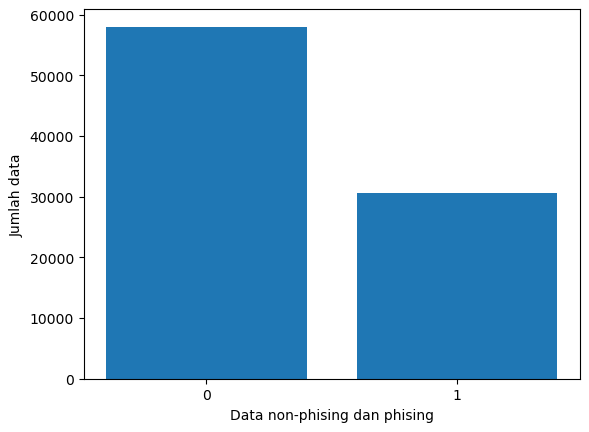

In [6]:
phishing_data = dataset_original['phishing'].value_counts()

plt.bar(phishing_data.index, phishing_data.values)
plt.xticks(ticks=phishing_data.index, labels=phishing_data.index)

plt.xlabel("Data non-phising dan phising")
plt.ylabel("Jumlah data")

print(f"Total 0 : {phishing_data.sum() - dataset_original['phishing'].sum()}")
print(f"Total 1 : {dataset_original['phishing'].sum()}")

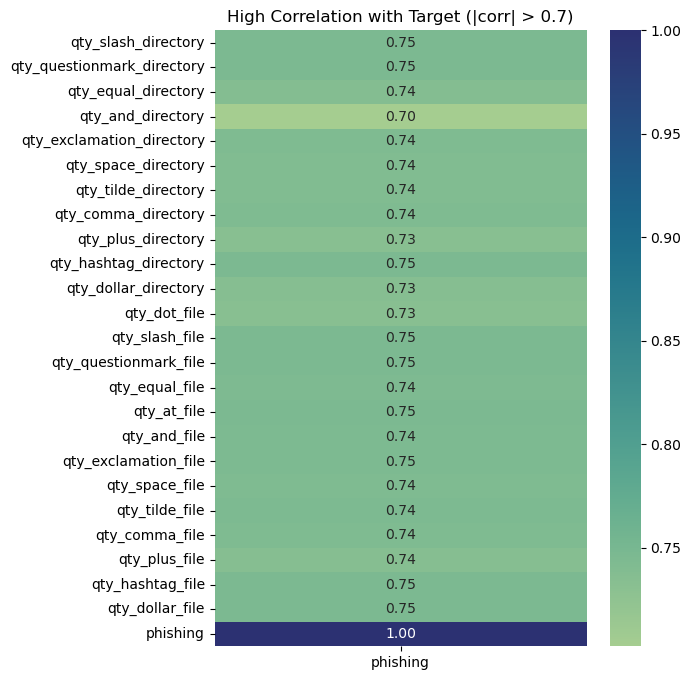

Features Count: 25


In [7]:
# Menghitung korelasi antar fitur
corr = dataset_original.corr()

# Menampilkan korelasi dengan target, misalnya 'target_column'
target_corr = corr['phishing']

high_corr = target_corr[abs(target_corr) > 0.7]

# Plot heatmap untuk korelasi tinggi
plt.figure(figsize=(6, 8))
sns.heatmap(high_corr.to_frame(), annot=True, cmap="crest", fmt=".2f", cbar=True)
plt.title("High Correlation with Target (|corr| > 0.7)")
plt.show()
print(f'Features Count: {len(high_corr.index.to_list())}')

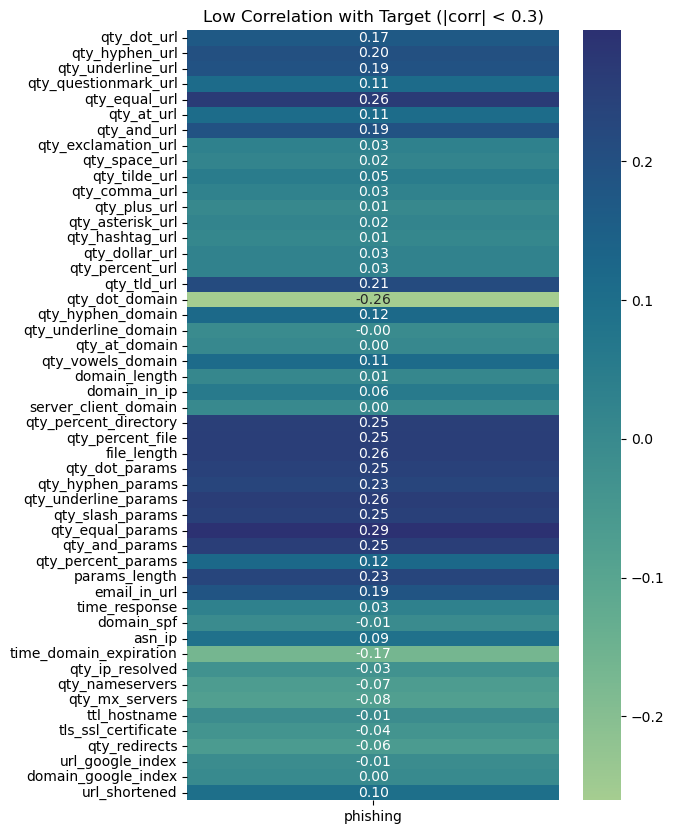

Features Count: 50


In [8]:
corr = dataset_original.corr()

target_corr = corr['phishing']

low_corr = target_corr[abs(target_corr) < 0.3]

plt.figure(figsize=(6, 10))
sns.heatmap(low_corr.to_frame(), annot=True, cmap="crest", fmt=".2f", cbar=True)
plt.title("Low Correlation with Target (|corr| < 0.3)")
plt.show()
print(f'Features Count: {len(low_corr.index.to_list())}')

# 3. Data Preprocessing

In [9]:
# @title Mengambil fitur yang diperlukan
high_corr_index = high_corr.index.to_list()

dataset = dataset_original[high_corr_index]

X = dataset.drop(columns='phishing')

y = dataset[['phishing']]

dataset.head()

,qty_slash_directory,qty_questionmark_directory,qty_equal_directory,qty_and_directory,qty_exclamation_directory,qty_space_directory,qty_tilde_directory,qty_comma_directory,qty_plus_directory,qty_hashtag_directory,...,qty_at_file,qty_and_file,qty_exclamation_file,qty_space_file,qty_tilde_file,qty_comma_file,qty_plus_file,qty_hashtag_file,qty_dollar_file,phishing
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0


In [10]:
dataset.shape

(88647, 25)

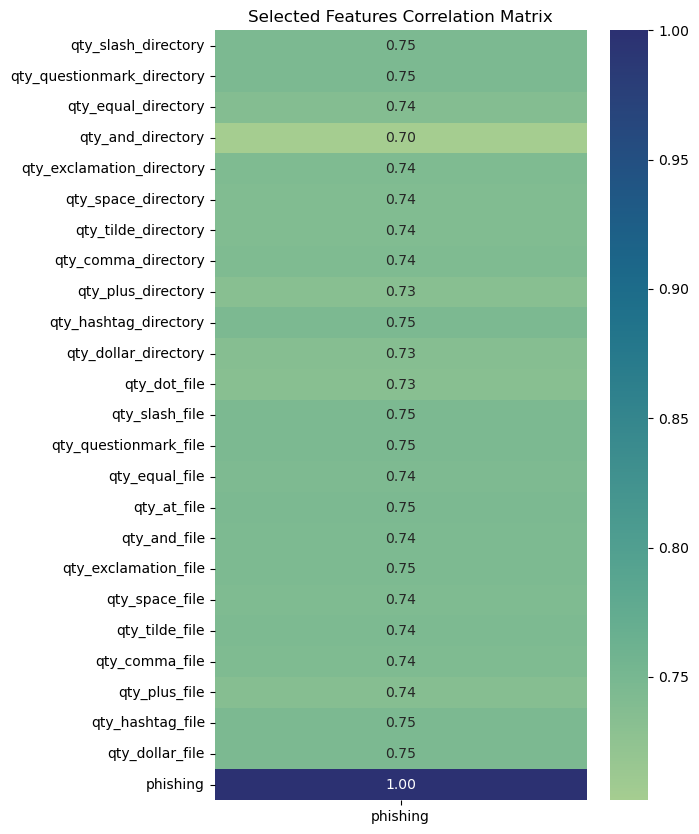

In [11]:
# Korelasi
corr = dataset.corr()

# Plot heatmap
plt.figure(figsize=(6, 10))
sns.heatmap(corr['phishing'].to_frame(), annot=True, cmap="crest", fmt=".2f")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title("Selected Features Correlation Matrix")
plt.show()

# 4. Splitting Dataset

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Banyak baris pada X_train : {X_train.shape[0]}")

Banyak baris pada X_train : 62052


In [13]:
print(f"Banyak baris pada X_test : {X_test.shape[0]}")

Banyak baris pada X_test : 26595


# 5. Model Selection & Implementation

In [14]:
# @title Preparing List for **algorithm accuracy**
accuracy_list = pd.DataFrame({
    "algorithm": ['K-Nearest Neighbors', 'Logistical Regression', 'Naive Bayes Classifier', 'Decision Tree', 'Random Forest'],
    "accuracy": [0.0,0.0,0.0,0.0,0.0]
})

accuracy_list

,algorithm,accuracy
0,K-Nearest Neighbors,0.0
1,Logistical Regression,0.0
2,Naive Bayes Classifier,0.0
3,Decision Tree,0.0
4,Random Forest,0.0


In [15]:
# @title Function for plotting confusion matrix
def plot_confusion_matrix(cm, title="Test"):
  plt.title(f"Confusion Matrix for {title}")
  sns.heatmap(cm, annot=True, fmt='d', cmap='crest', xticklabels=['Not Phising', 'Phising'], yticklabels=['Not Phising', 'Phising'])
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.yticks(rotation=0)
  plt.show()

## 5.1 K-Nearest Neighbors

In [16]:
# @title Library that being used for **K-Nearest Neighbors**
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [17]:
# @title Making the model with **K-Nearest Neighbors**
classifier_knn = KNeighborsClassifier(n_neighbors=5)
classifier_knn.fit(X_train.values, y_train.values.ravel())
y_pred_knn = classifier_knn.predict(X_test.values)

In [18]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.98      0.81      0.89     17449
           1       0.73      0.98      0.83      9146

    accuracy                           0.87     26595
   macro avg       0.86      0.89      0.86     26595
weighted avg       0.90      0.87      0.87     26595



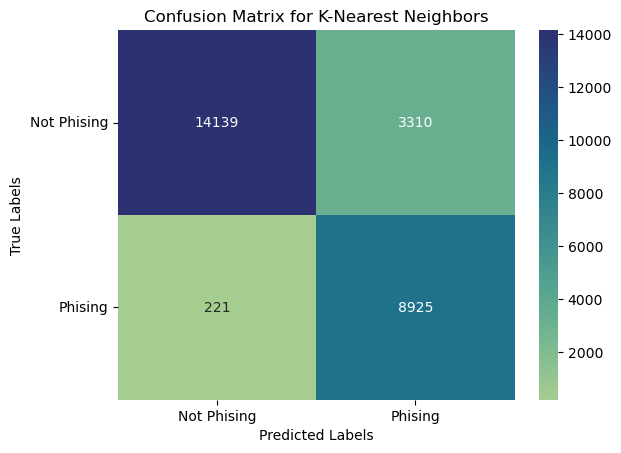

In [19]:
cm_knn = confusion_matrix(y_test, y_pred_knn)

plot_confusion_matrix(cm_knn, title="K-Nearest Neighbors")

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_list.loc[accuracy_list['algorithm'] == 'K-Nearest Neighbors', 'accuracy'] = accuracy_score(y_test, y_pred_knn)

print(f"KNN accuracy : {accuracy_score(y_test, y_pred_knn)}")

Random Forest accuracy : 0.8672306824591088


## 5.2 Logistical Regression

In [22]:
# @title Library that being used for **Logistical Regression**
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

In [24]:
# @title Making the model with **Logistical Regression**
classifier_lr = LogisticRegression(max_iter=1000)
classifier_lr.fit(X_train.values,y_train.values.ravel())
y_pred_lr = classifier_lr.predict(X_test.values)

In [25]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91     17449
           1       0.84      0.81      0.82      9146

    accuracy                           0.88     26595
   macro avg       0.87      0.86      0.87     26595
weighted avg       0.88      0.88      0.88     26595



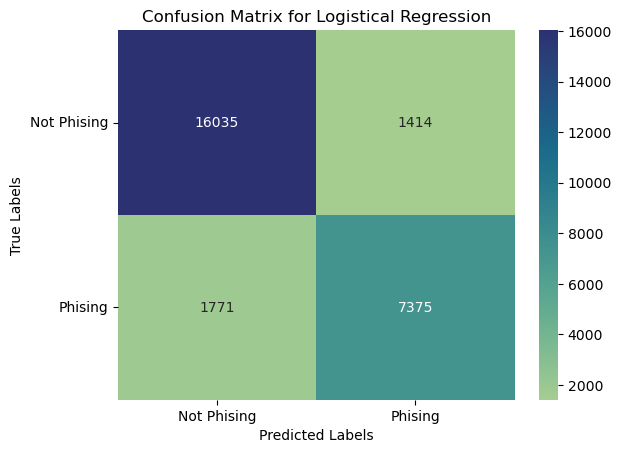

In [26]:
from sklearn.metrics import confusion_matrix

cm_lr = confusion_matrix(y_test, y_pred_lr)

plot_confusion_matrix(cm_lr, title="Logistical Regression")

In [51]:
from sklearn.metrics import accuracy_score

accuracy_list.loc[accuracy_list['algorithm'] == 'Logistical Regression', 'accuracy'] = accuracy_score(y_test, y_pred_lr)

print(f"Logistical Regression accuracy : {accuracy_score(y_test, y_pred_lr)}")

Logistical Regression accuracy : 0.8802406467381086


## 5.3 Naive Bayes Classifier

In [27]:
# @title Library that being used for **Naive Bayes Classifier**
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix


In [28]:
# @title Making the model with **Naive Bayes Classifier**
nb_model = GaussianNB()
nb_model.fit(X_train, y_train.values.ravel())
y_pred = nb_model.predict(X_test)

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.81      0.89     17449
           1       0.73      0.97      0.83      9146

    accuracy                           0.87     26595
   macro avg       0.86      0.89      0.86     26595
weighted avg       0.90      0.87      0.87     26595



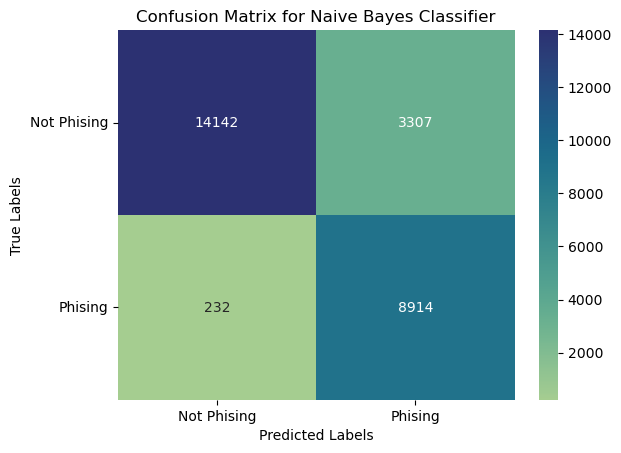

In [30]:
from sklearn.metrics import confusion_matrix

cm_nb = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_nb, title="Naive Bayes Classifier")

In [31]:
from sklearn.metrics import accuracy_score

nb_accuracy = accuracy_score(y_test, y_pred)

accuracy_list.loc[accuracy_list['algorithm'] == 'Naive Bayes Classifier', 'accuracy'] = nb_accuracy

print(f"Naive Bayes Classifier accuracy : {nb_accuracy}")


Naive Bayes Classifier accuracy : 0.866929874036473


## 5.4 Decision Tree

In [32]:
# @title Library that being used for **Decision Tree**
from sklearn.metrics import classification_report
from sklearn import tree

In [33]:
# @title Making the model with **Decision Tree**
classifier_dt = tree.DecisionTreeClassifier(max_depth=7)
classifier_dt.fit(X_train.values,y_train.values)
y_pred_dt = classifier_dt.predict(X_test.values)

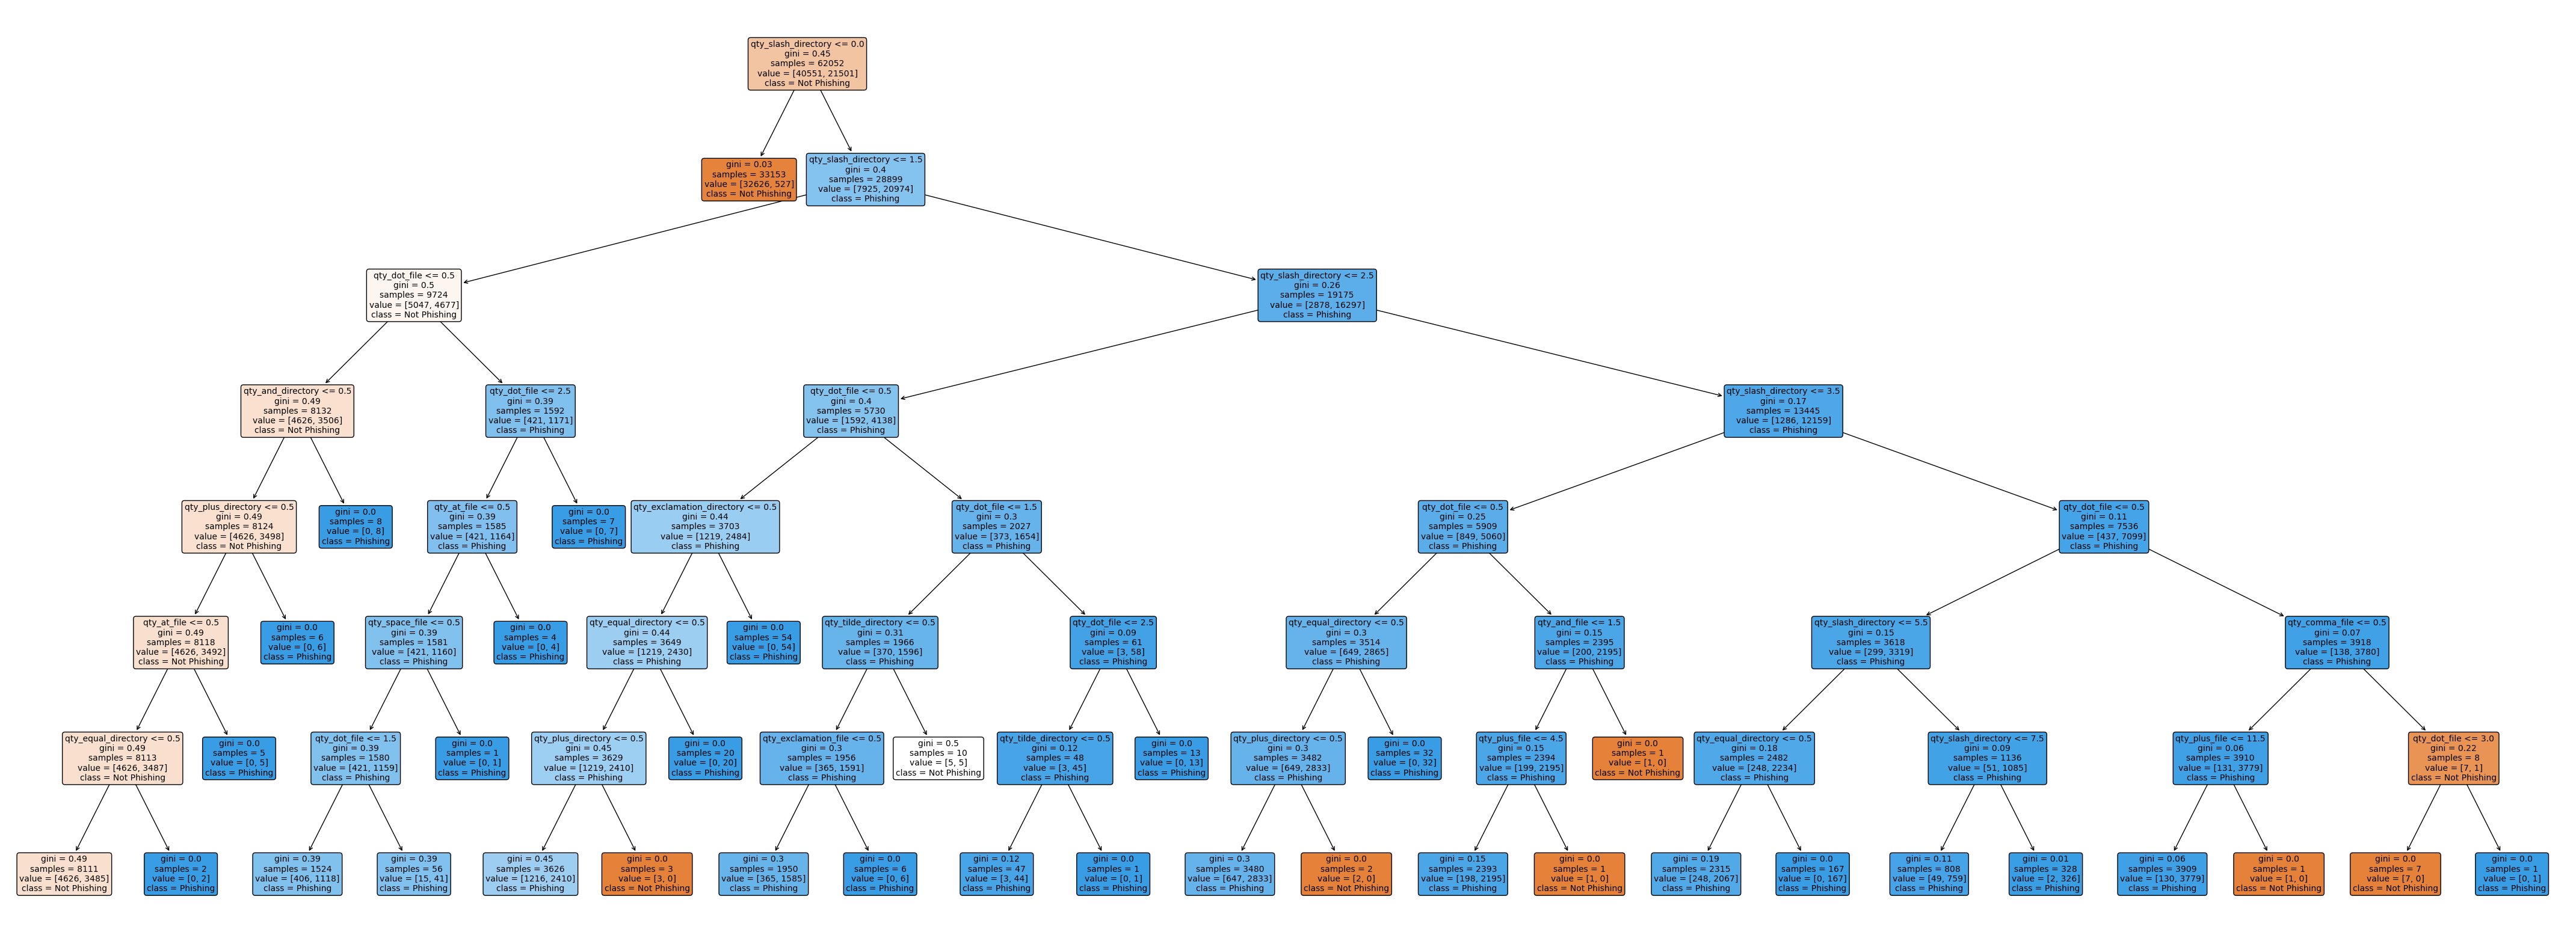

In [40]:
plt.figure(figsize=(55, 20))
tree.plot_tree(
  classifier_dt,
  feature_names=list(X),
  class_names=['Not Phishing', 'Phishing'],
  filled=True,
  rounded=True,
  fontsize=10,
  precision=2
)
plt.show()

In [41]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91     17449
           1       0.84      0.81      0.82      9146

    accuracy                           0.88     26595
   macro avg       0.87      0.86      0.87     26595
weighted avg       0.88      0.88      0.88     26595



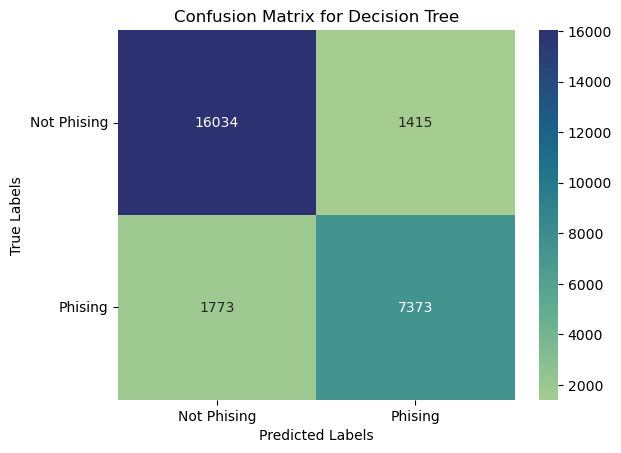

In [42]:
from sklearn.metrics import confusion_matrix

cm_dt = confusion_matrix(y_test, y_pred_dt)

plot_confusion_matrix(cm_dt, title="Decision Tree")

In [43]:
from sklearn.metrics import accuracy_score

accuracy_list.loc[accuracy_list['algorithm'] == 'Decision Tree', 'accuracy'] = accuracy_score(y_test, y_pred_dt)

print(f"Decision Tree accuracy : {accuracy_score(y_test, y_pred_dt)}")

Decision Tree accuracy : 0.8801278435796203


## 5.5 Random Forest

In [44]:
# @title Library that being used for **Random Forest**
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

In [45]:
# @title Making the model with **Random Forest**
classifier_rf = RandomForestClassifier(n_estimators=100)
classifier_rf.fit(X_train.values,y_train.values.ravel())
y_pred_rf = classifier_rf.predict(X_test.values)

In [46]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91     17449
           1       0.84      0.81      0.82      9146

    accuracy                           0.88     26595
   macro avg       0.87      0.86      0.87     26595
weighted avg       0.88      0.88      0.88     26595



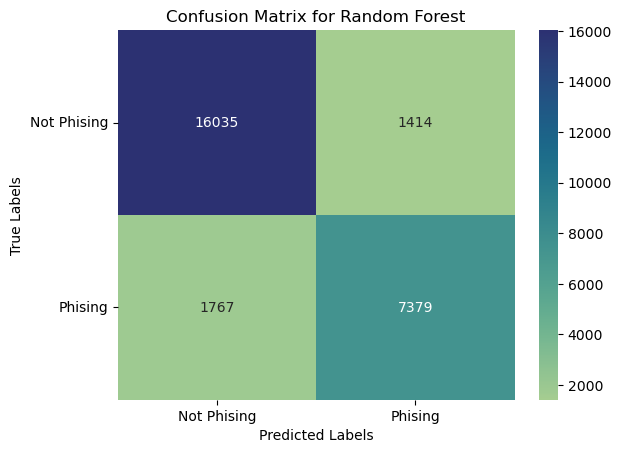

In [47]:
from sklearn.metrics import confusion_matrix

cm_rf = confusion_matrix(y_test, y_pred_rf)

plot_confusion_matrix(cm_rf, title="Random Forest")

In [48]:
from sklearn.metrics import accuracy_score

accuracy_list.loc[accuracy_list['algorithm'] == 'Random Forest', 'accuracy'] = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest accuracy : {accuracy_score(y_test, y_pred_rf)}")

Random Forest accuracy : 0.8803910509494266


# 6. Model Evaluation

In [52]:
accuracy_list

,algorithm,accuracy
0,K-Nearest Neighbors,0.867231
1,Logistical Regression,0.880241
2,Naive Bayes Classifier,0.866930
3,Decision Tree,0.880128
4,Random Forest,0.880391


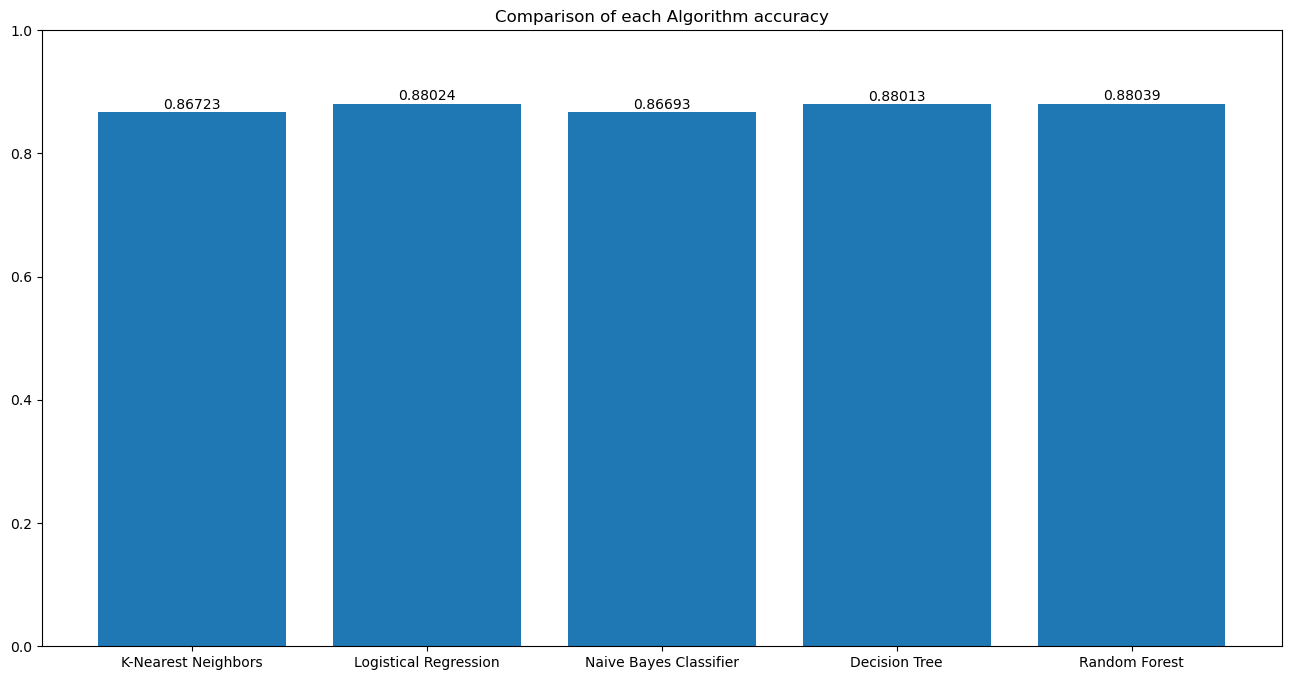

In [53]:
plt.figure(figsize=(16,8))
bars = plt.bar(accuracy_list['algorithm'], accuracy_list['accuracy'])
plt.ylim(0, 1)
plt.title("Comparison of each Algorithm accuracy")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.001, f'{yval:.5f}', ha='center', va='bottom')

plt.show()

# 7. Conclusion & Deployment

In [54]:
from app.utils import extract_features

# References
- [urls-classification(burusbetulcavusoglu)](https://www.kaggle.com/code/busrabetulcavusoglu/urls-classification)
- [Kagglehub](https://github.com/Kaggle/kagglehub)